Part 1: Acquisition de données

In [1]:
import requests
import json
import os
import time

Logique générale pour l'acquisition des données:

Logique générale
a) Classe pour téléchargement de données
b) Téléchargement des matches des saisons régulières de 2016 à 2023 et sauvegarde dans le repertoire data/nhl_reguliere2
c) Téléchargement des matches des playoffs de 2016 à 2023 et sauvegarde dans le repertoire data/nhl_playoffs2
d) Fusion des deux repertoires data/nhl_reguliere2 et data/nhl_playoffs2 dans data/nhl_data

a) Classe pour téléchargement de données

In [2]:
import os
import requests
import json
import time

class NHLDataDownloader:
    def __init__(self, base_dir):
        """
        Initialise le répertoire où les données seront sauvegardées.
        :param base_dir: Chemin du répertoire local pour la sauvegarde des données
        """
        self.base_dir = base_dir
        if not os.path.exists(base_dir):
            os.makedirs(base_dir)

    def download_game_data(self, game_id: str) -> dict:
     """
    Télécharge les données d'un match spécifique depuis l'API de la LNH.
    Si le fichier existe déjà localement, il est chargé depuis le disque.
    :param game_id: L'identifiant unique du match (ex. '2020020001' pour le premier match de la saison 2020-21)
    :return: Un dictionnaire contenant les données du match, ou None en cas d'erreur
    """
     file_path = os.path.join(self.base_dir, f"{game_id}.json")
     if os.path.exists(file_path):
        print(f"Fichier {game_id}.json déjà existant dans le répertoire {self.base_dir}.")
        with open(file_path, 'r', encoding='utf-8') as f:
                game = json.load(f)
                return game
     else:
        game_type = str(game_id)[4:6]
        game = None  # Initialisation de la variable 'game'
        if game_type == '02' or game_type == '03':
            url = f"https://api-web.nhle.com/v1/gamecenter/{str(game_id)}/play-by-play"
            try:
                response = requests.get(url)
                response.raise_for_status()  # Vérifie si la requête a réussi
                game = response.json()
                with open(os.path.join(self.base_dir, f"{game_id}.json"), 'w', encoding='utf-8') as f:
                    json.dump(game, f, ensure_ascii=False, indent=4)
                    f.close()
                    print(f"Téléchargé et enregistré : {game_id}.json")
            except Exception as e:
                print(f"Erreur de téléchargement du match {game_id}: {e}")
            time.sleep(1)  # Délai d'une seconde entre les requêtes
        return game                        

Exemple de téléchargement d'un fichier existent et d'un fichier non-existent

In [3]:
gameid = "2017020001"
# Utilisation de la classe
downloader = NHLDataDownloader(base_dir='data/test')

# Télécharge les données pour la saison 2016 (saison régulière et playoffs)
downloader.download_game_data(2016020001)
downloader.download_game_data(2016020002)

Téléchargé et enregistré : 2016020001.json
Téléchargé et enregistré : 2016020002.json


{'id': 2016020002,
 'season': 20162017,
 'gameType': 2,
 'limitedScoring': False,
 'gameDate': '2016-10-12',
 'venue': {'default': 'United Center'},
 'venueLocation': {'default': 'Chicago'},
 'startTimeUTC': '2016-10-13T00:00:00Z',
 'easternUTCOffset': '-04:00',
 'venueUTCOffset': '-05:00',
 'tvBroadcasts': [{'id': 241,
   'market': 'N',
   'countryCode': 'US',
   'network': 'NBCSN',
   'sequenceNumber': 13}],
 'gameState': 'OFF',
 'gameScheduleState': 'OK',
 'periodDescriptor': {'number': 3,
  'periodType': 'REG',
  'maxRegulationPeriods': 3},
 'awayTeam': {'id': 19,
  'name': {'default': 'Blues'},
  'abbrev': 'STL',
  'score': 5,
  'sog': 33,
  'logo': 'https://assets.nhle.com/logos/nhl/svg/STL_light.svg',
  'darkLogo': 'https://assets.nhle.com/logos/nhl/svg/STL_dark.svg',
  'placeName': {'default': 'St. Louis'},
  'placeNameWithPreposition': {'default': 'St. Louis', 'fr': 'de St. Louis'}},
 'homeTeam': {'id': 16,
  'name': {'default': 'Blackhawks'},
  'abbrev': 'CHI',
  'score': 2,


b) Téléchargement des matchs des saisons régulières de 2016 à 2023 et sauvegarde dans le repertoire data/nhl_reguliere2

In [4]:
# Utilisation de la classe
downloader = NHLDataDownloader(base_dir='data/nhl_reguliere2')

def download_all_seasons(downloader, start_year, end_year):    
    # Cette partie a seulement relation avec la saison régulière (type 2) 
    """
    Télécharge les données pour des saisons de la LNH.
    :param downloader: Une instance de la classe NHLDataDownloader
    :param year: Année de début de la saison (ex. '2020')
    :param no_of_games: Nombre de matchs à télécharger pour la saison régulière (ex. 1271)
    :param game_type: '02' pour la saison régulière
    """

    
    for year in range(start_year, end_year + 1):
        year_str = str(year)
        
        # Définir le nombre de matchs en fonction de l'année
        if year_str == '2016':
            no_of_games = 1231  # 1230 matches in 2016
        elif year_str == '2020':
            no_of_games = 869  # 868 matches in 2020 because of covid
        elif year_str in ['2017', '2018', '2019']:
            no_of_games = 1272  # Matches normaux pour ces années
        else:
            no_of_games = 1354  # Pour les années 2021 et après (32 équipes)

        print(f"Téléchargement des données de la saison {year_str} pour {no_of_games} matchs.")

        # Boucler sur les IDs de match pour télécharger les données de la saison régulière (type 02)
        for game_number in range(1, no_of_games + 1):
            game_id = f"{year_str}02{str(game_number).zfill(4)}"  # Format de l'ID de jeu
            game_data = downloader.download_game_data(game_id=game_id)

            # Vérifier le contenu des données téléchargées
            if game_data:
                print(f"Données pour le game_id {game_id} téléchargées avec succès.")
            else:
                print(f"Aucune donnée disponible pour le game_id {game_id}.")



In [5]:
# Télécharger toutes les saisons de 2016 à 2023
download_all_seasons(downloader, start_year=2016, end_year=2023)

Téléchargement des données de la saison 2016 pour 1231 matchs.
Téléchargé et enregistré : 2016020001.json
Données pour le game_id 2016020001 téléchargées avec succès.
Téléchargé et enregistré : 2016020002.json
Données pour le game_id 2016020002 téléchargées avec succès.
Téléchargé et enregistré : 2016020003.json
Données pour le game_id 2016020003 téléchargées avec succès.
Téléchargé et enregistré : 2016020004.json
Données pour le game_id 2016020004 téléchargées avec succès.
Téléchargé et enregistré : 2016020005.json
Données pour le game_id 2016020005 téléchargées avec succès.
Téléchargé et enregistré : 2016020006.json
Données pour le game_id 2016020006 téléchargées avec succès.
Téléchargé et enregistré : 2016020007.json
Données pour le game_id 2016020007 téléchargées avec succès.
Téléchargé et enregistré : 2016020008.json
Données pour le game_id 2016020008 téléchargées avec succès.
Téléchargé et enregistré : 2016020009.json
Données pour le game_id 2016020009 téléchargées avec succès.
T

KeyboardInterrupt: 

c) Téléchargement des matches des playoffs de 2016 à 2023 et sauvegarde dans le repertoire data/nhl_playoffs2

In [ ]:
# Utilisation de la classe
downloader = NHLDataDownloader(base_dir='data/nhl_playoffs2')
def download_playoffs_data(downloader,start_year, end_year) -> None:
    """
        Fonction utilisant des appels REST calls pour télécharger les données des playoffs des saisons allant de start_year à end_year. Sauvegarde le résultat json dans le path 
        défini dans la classe NHLDataDownloader
        :param start_year: année de début de la liste écrite en 4-digits.
        :param end_year: année de fin de la liste écrite en 4-digits.
        :return: None

        """
    #Premier tour des playoffs (1/8 de finale) : 0301
    #Deuxième tour (quarts de finale) : 0302
    #Troisième tour (demi-finales) : 0303
    # Finale : 0304
       
    for year in range(start_year, end_year + 1):
        year_str = str(year)
        print(f"Téléchargement des données des playoffs pour la saison {year_str}")

        # Générer les IDs des matchs de playoffs
        playoffs = []
        # Huitièmes de finale
        playoffs.extend([f"{year_str}0301{str(matchup)}{game_number}" for matchup in range(1, 9) for game_number in range(1, 8)])
        # Quarts de finale
        playoffs.extend([f"{year_str}0302{str(matchup)}{game_number}" for matchup in range(1, 5) for game_number in range(1, 8)])   
        # Demi-finales
        playoffs.extend([f"{year_str}0303{str(matchup)}{game_number}" for matchup in range(1, 3) for game_number in range(1, 8)])   
        # Finales
        playoffs.extend([f"{year_str}0304{str(1)}{game_number}" for game_number in range(1, 8)])        
        
        # Télécharger chaque match de playoffs
        for game_id in playoffs:
            game_data = downloader.download_game_data(game_id=game_id)
            # Vérifier le contenu des données téléchargées
            if game_data:
                print(f"Données pour le game_id {game_id} téléchargées avec succès.")
            else:
                print(f"Aucune donnée disponible pour le game_id {game_id}.")

# Télécharger toutes les données des playoffs de 2016 à 2023
download_playoffs_data(downloader, start_year=2016, end_year=2023)

d) Fusion des deux repertoires data/nhl_reguliere2 et data/nhl_playoffs2 dans data/nhl_data

In [ ]:
import os
import shutil

# Define the paths to your folders
reguliere_folder = 'data/nhl_reguliere2'
playoffs_folder = 'data/nhl_playoffs2'
destination_folder ='data/nhl_data'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Function to copy files from a source folder to the destination folder
def copy_files(source_folder, destination_folder):
    # Loop through all files in the source folder
    for filename in os.listdir(source_folder):
            source_file = os.path.join(source_folder, filename)
            destination_file = os.path.join(destination_folder, filename)

            # Copy the file to the destination folder
            shutil.copy(source_file, destination_file)
            print(f"Copied {filename} to {destination_folder}")

# Copy files from both nhl_reguliere and nhl_playoffs to nhl_data
copy_files(reguliere_folder, destination_folder)
copy_files(playoffs_folder, destination_folder)

print("All files have been copied successfully.")

## Deb0ggeur interactif

In [6]:
pip install matplotlib seaborn ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Imports for JupyterLite
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass
import ipywidgets as widgets
from IPython.display import display

In [8]:
def read_files_json(folder):
    # Créer un dictionnaire pour stocker les données de tous les fichiers
    all_data = {}
    # Liste pour suivre les fichiers qui ont été lus
    files_read = []

    # Parcourir tous les fichiers dans le dossier spécifié
    for filename in os.listdir(folder):
        # Vérifier si le fichier a l'extension '.json'
        is_json = filename.endswith('.json')
        # Enlever l'extension '.json' pour obtenir le nom de base du fichier
        name = filename.replace('.json', '')
        
        if is_json:
            # Ouvrir et charger le fichier avec encodage utf-8
            try:
                with open(f"{folder}{filename}", encoding='utf-8') as file:
                    # Charger le contenu JSON du fichier dans un dictionnaire
                    file_dict = json.load(file)
                    # Ajouter le nom du fichier à la liste des fichiers lus
                    files_read.append(name)
                    # Ajouter les données du fichier au dictionnaire, avec le nom du fichier comme clé
                    all_data[name] = file_dict
            except UnicodeDecodeError as e:
                # Afficher un message d'erreur si un problème d'encodage se produit
                print(f"Erreur de décodage du fichier {filename}: {e}")
    
    # Afficher la liste des fichiers qui ont été lus avec succès
    print(f"Fichiers lus : {files_read}")
    return all_data

# Charger toutes les données des fichiers JSON dans le dossier 'data/nhl_data/'
data = read_files_json('data/nhl_data/')

# Charger l'image de la patinoire pour l'affichage des événements
rink = plt.imread("nhl_rink.png")



Fichiers lus : ['2022020671', '2023020320', '2021020828', '2019020910', '2018020811', '2021020982', '2022020221', '2018030112', '2023020770', '2018020542', '2022021060', '2017020495', '2019020013', '2020020180', '2018020112', '2021020081', '2016020594', '2023021161', '2022030221', '2019020443', '2016020081', '2019020156', '2018020407', '2021020594', '2022021125', '2023021024', '2019020506', '2020020495', '2018020057', '2017020180', '2016020982', '2023020265', '2017020929', '2019020855', '2018021216', '2022020734', '2023020635', '2018020954', '2016020828', '2022020364', '2017020883', '2021020717', '2018020684', '2017020753', '2016020202', '2020020246', '2021020347', '2017020303', '2016020652', '2020020616', '2019020785', '2018021095', '2021021106', '2017021142', '2016021043', '2022020108', '2021021043', '2023020459', '2017021007', '2022020558', '2016021106', '2017030246', '2023020009', '2016020347', '2020020303', '2019020290', '2021020652', '2017020616', '2023021248', '2016020717', '202

FileNotFoundError: [Errno 2] No such file or directory: 'nhl_rink.png'

Afficher certaines parties des données chargées dans data

In [10]:
# Charger l'image de la patinoire pour l'affichage des événements
rink = plt.imread("figures/nhl_rink.png")

In [11]:
# Afficher les clés principales dans 'data'
print("Clés principales dans data :", list(data.keys()))

# Afficher les premières parties d'un fichier spécifique (par exemple, le premier fichier lu dans la variable 'data'):
first_key = list(data.keys())[0]
print(f"Contenu partiel du fichier '{first_key}' :")
print(data[first_key])

# Parcourir plusieurs fichiers et afficher certains éléments
for file_key in list(data.keys())[:3]:  # Limitez l'affichage à 3 fichiers pour éviter de trop de sorties
    print(f"Contenu du fichier '{file_key}':")
    print(data[file_key], "\n")  # Affichez le contenu complet ou limitez à des parties spécifiques selon vos besoins

Clés principales dans data : ['2022020671', '2023020320', '2021020828', '2019020910', '2018020811', '2021020982', '2022020221', '2018030112', '2023020770', '2018020542', '2022021060', '2017020495', '2019020013', '2020020180', '2018020112', '2021020081', '2016020594', '2023021161', '2022030221', '2019020443', '2016020081', '2019020156', '2018020407', '2021020594', '2022021125', '2023021024', '2019020506', '2020020495', '2018020057', '2017020180', '2016020982', '2023020265', '2017020929', '2019020855', '2018021216', '2022020734', '2023020635', '2018020954', '2016020828', '2022020364', '2017020883', '2021020717', '2018020684', '2017020753', '2016020202', '2020020246', '2021020347', '2017020303', '2016020652', '2020020616', '2019020785', '2018021095', '2021021106', '2017021142', '2016021043', '2022020108', '2021021043', '2023020459', '2017021007', '2022020558', '2016021106', '2017030246', '2023020009', '2016020347', '2020020303', '2019020290', '2021020652', '2017020616', '2023021248', '201

## Logique générale du déboggeur:

Le code implémente un débogueur interactif qui comporte une interface permettant de naviguer dans différents événements, saisons et types de jeux.

a) Initialisation des variables (__init__) :

Lorsque le débogueur est instancié, les données du jeu sont chargées et certaines variables sont définies pour gérer les informations sur la saison, le type de jeu (saison régulière ou playoffs), l'ID du jeu et l'événement en cours.
Les widgets (curseurs, boutons de bascule, etc.) sont initialisés pour permettre à l'utilisateur de sélectionner la saison, le type de jeu, l'ID du match et l'événement spécifique à afficher.


b) Widgets interactifs :

Slider de saison : Permet de sélectionner la saison à explorer.
Boutons de bascule : Permettent de basculer entre les matchs de la saison régulière et les matchs des playoffs.
Slider d'ID de match : Permet de sélectionner un match spécifique dans la saison.
Slider d'événement : Permet de parcourir les événements d'un match (par exemple, tirs, face-offs, buts).

c) Fonction season_range() :
Cette fonction parcourt les fichiers JSON du répertoire pour déterminer la saison minimale et maximale disponibles dans les données.
Elle renvoie une plage de saisons permettant d'ajuster dynamiquement le slider de saison.


d) Affichage des coordonnées de l'événement (plot_coordinates()) :
Affiche les coordonnées d'un événement (par exemple, un tir) sur une image d'une patinoire, si les coordonnées sont disponibles. Utilise matplotlib pour superposer les coordonnées sur l'image de la patinoire.


e) Affichage des informations du jeu et de l'événement (display_info()) :
Affiche des détails tels que l'ID du match, les équipes participantes, la date du match, le score final, le nombre d'événements et la description de l'événement actuel.
Inclut également le nom du stade et la ville où se déroule le match, ainsi que des détails sur l'événement (période, temps écoulé).

f) Filtrage des données (filter_season() et filter_playoffs()) :

filter_season() : Filtre les jeux en fonction de la saison sélectionnée par l'utilisateur.
filter_playoffs() : Filtre les jeux en fonction du type de jeu sélectionné (saison régulière ou playoffs).

g) Mise à jour des variables du jeu et de l'événement (update_vars()) :
Met à jour les variables qui contiennent des informations sur le jeu en cours et l'événement sélectionné.
Cela inclut la mise à jour des informations sur les équipes, le score, le stade, la ville, les coordonnées de l'événement, la description, et d'autres détails pertinents.

H) Mise à jour dynamique via widgets (update_*()) :
Ces fonctions sont déclenchées à chaque fois que l'utilisateur modifie un widget. Elles mettent à jour la saison, le type de jeu, l'ID du jeu ou l'événement, et actualisent les informations affichées :
update_season() : Met à jour les jeux en fonction de la saison choisie.
update_game_type() : Met à jour les jeux en fonction du type de jeu (Playoffs ou Saison régulière).
update_game_id() : Met à jour les informations pour l'ID du jeu sélectionné.
update_event() : Met à jour les informations pour l'événement sélectionné dans le jeu.


I) Affichage final (display_output()) :
La fonction display_output() permet de rendre visible le widget interactif, en affichant toutes les informations mises à jour en fonction des sélections faites par l'utilisateur.

Une remarque pour l'extraction du time pour l'heure de démarrage du match
Ce temps est disponible dans le champ startTimeUTC	"2024-02-11T00:00:00Z" du ficier json sauvegardé.
Le format T00:00:00Z fait partie de la norme ISO 8601, qui est utilisée pour représenter des dates et des heures dans un format standardisé à l'échelle internationale.

T :
Le caractère T est utilisé comme séparateur entre la date et l'heure. Par exemple, dans la chaîne 2024-02-11T00:00:00Z, la partie avant le T (2024-02-11) représente la date (11 février 2024), et la partie après le T (00:00:00) représente l'heure.

00:00:00 :
Représente l'heure sous le format heures:minutes. Ici, 00:00:00 signifie minuit ou 00h00 (minuit, pile).

Z :
Le Z à la fin est une indication du fuseau horaire. Plus précisément, le Z signifie que l'heure est exprimée en temps universel coordonné (UTC), aussi appelé Zulu Time.
En pratique, cela signifie que l'heure indiquée (00:00:00) correspond à 00h00 UTC.
Donc: 
Date : 11 février 2024.
Heure:  T00:00:00Z signifie minuit (00h00) en temps universel coordonné (UTC).

In [15]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import json
import os

class Debugger_interactif:
    def __init__(self, data):
        # Initialisation des variables
        self.data = data
        
        # Variables principales
        self.current_data = data  # Contient le dictionnaire des données actuelles (peut être filtré)
        self.current_season = str('2016')  # Saison actuelle
        self.current_game_type = 'Saison régulière'  # Type de jeu actuel (saison régulière ou playoffs)
        self.current_game_id = '2016020122'  # Match actuel (initialisé au premier)
        self.current_event = 1  # Événement actuel

        # Variables descriptives utilisées pour décrire l'événement
        self.update_vars()  # Initialisation des variables liées au jeu

        # Widgets
        self.output = widgets.Output()  # Contrôle la sortie

        # Slider pour sélectionner la saison
        self.season = widgets.IntSlider(
            value=int(self.season_range()[0]),
            min=int(self.season_range()[0]),
            max=int(self.season_range()[1]),
            description="Saison"
        )
        self.season.observe(self.update_season, 'value')

        # Boutons pour basculer entre saison régulière et playoffs
        self.game_type = widgets.ToggleButtons(options=['Saison régulière', 'Playoffs'])
        self.game_type.observe(self.update_game_type, 'value')

        # Slider pour sélectionner un match particulier
        self.game_id = widgets.SelectionSlider(
            options=sorted(list(self.current_data.keys())),
            value=self.current_game_id,
            description='ID de match',
        )
        self.game_id.observe(self.update_game_id, 'value')

        # Slider pour sélectionner un événement particulier
        self.event = widgets.IntSlider(
            value=1,
            min=1,
            max=len(self.current_data[self.current_game_id]['plays']),
            description='Événement'
        )
        self.event.observe(self.update_event, 'value')

    def season_range(self):
        """Liste les fichiers dans le dossier 'data' et renvoie la saison minimale et maximale."""
        min_season = 3000
        max_season = 0
        for game_id in self.data.keys():
            season = int(game_id[:4])
            if season < min_season:
                min_season = season
            if season > max_season:
                max_season = season
        return (str(min_season), str(max_season))

    def plot_coordinates(self):
        """Affiche les coordonnées de l'événement sur l'image de la patinoire."""
        if self.x_coordinates is not None and self.y_coordinates is not None:
            rink = plt.imread("nhl_rink.png")  # Remplacez par le bon chemin d'image
            plt.imshow(rink, zorder=0, extent=[-100, 100, -42.5, 42.5])
            plt.scatter(self.x_coordinates, self.y_coordinates, zorder=1, c='blue', marker='o', s=100)
            plt.title(self.event_time, fontsize=10)
            plt.suptitle(self.event_description, fontsize=16, y=.90)
            plt.xlabel('feet')
            plt.ylabel('feet')
            plt.show()

    def display_info(self):
        """Affiche les informations sur le match et l'événement sélectionnés."""
        with self.output:
            self.output.clear_output()  # Efface les sorties précédentes
            if self.current_game_id:
                print(f"ID de match : {self.current_game_id}")
                print(f"Numéro de match : {self.current_game_id[-4:].lstrip('0')}")
                print(f"{self.home_team} (domicile) vs. {self.away_team} (extérieur)")
                print(f"Début du match : {self.start_time}")
                print(f"Score final : {self.home_team} {self.final_score_home} - {self.final_score_away} {self.away_team}")
                print(f"Nombre total d'événements : {len(self.current_data[self.current_game_id]['plays'])}")
                print(f"Stade : {self.venue_name}, Lieu : {self.venue_city}")
                print(f"Description de l'événement actuel : {self.event_description}")
                print(f"Période : {self.event_period}, Temps dans la période : {self.event_time}")
                self.plot_coordinates()
                print("Détails de l'événement :")
                print(self.about_event)
            else:
                print("Aucune donnée disponible.")

    def filter_season(self):
        """Filtre les données selon la saison sélectionnée."""
        filtered_data = {game_id: data for game_id, data in self.data.items() if game_id.startswith(self.current_season)}
        self.current_data = filtered_data if filtered_data else self.data

    def filter_playoffs(self):
        """Filtre les données pour ne garder que les matchs de playoffs ou de saison régulière."""
        filtered_data = {}
        for game_id in self.current_data.keys():
            if self.current_game_type == "Playoffs" and game_id[4:6] == '03':
                filtered_data[game_id] = self.current_data[game_id]
            elif self.current_game_type == "Saison régulière" and game_id[4:6] == '02':
                filtered_data[game_id] = self.current_data[game_id]
        self.current_data = filtered_data

    def update_vars(self):
        """Met à jour les variables liées au jeu et à l'événement."""
        if not self.current_game_id:
            return
        game = self.current_data.get(self.current_game_id, {})
        self.home_team = game.get('homeTeam', {}).get('abbrev', 'N/A')
        self.away_team = game.get('awayTeam', {}).get('abbrev', 'N/A')
        
        # Extraction de l'heure de début du match, et récupération de la partie "T00:00:00Z"
        start_time_full = game.get('startTimeUTC', 'Inconnue')
        self.start_time = start_time_full.split('T')[-1] if 'T' in start_time_full else 'Inconnue'


        self.final_score_away = game.get('summary', {}).get('linescore', {}).get('totals', {}).get('away', 'N/A')
        self.final_score_home = game.get('summary', {}).get('linescore', {}).get('totals', {}).get('home', 'N/A')
       # Extraction des informations du stade et de la ville
        self.venue_name = game.get('venue', {}).get('default', 'Stade inconnu')
        self.venue_city = game.get('venueLocation', {}).get('default', 'Ville inconnue')


        event_details = game['plays'][self.current_event].get('details', {})
        self.x_coordinates = event_details.get('xCoord', None)
        self.y_coordinates = event_details.get('yCoord', None)
        self.event_description = game['plays'][self.current_event].get('typeDescKey', 'Aucune description')
        self.event_time = game['plays'][self.current_event].get('timeInPeriod', 'Temps inconnu')
        self.event_period = game['plays'][self.current_event].get('periodDescriptor', {}).get('number', 'Période inconnue')
        self.about_event = game['plays'][self.current_event]

    def update_season(self, x):
        """Met à jour la saison en fonction du choix de l'utilisateur."""
        self.output.clear_output()
        with self.output:
            self.current_season = str(x.new)
            self.filter_season()
            self.filter_playoffs()
            if self.current_game_id:
                self.game_id.options = sorted(list(self.current_data.keys()))
                self.update_vars()
                self.display_info()

    def update_game_type(self, x):
        """Met à jour le type de jeu en fonction de la sélection (Playoffs ou Saison régulière)."""
        self.output.clear_output()
        with self.output:
            self.current_game_type = x.new
            self.filter_season()
            self.filter_playoffs()
            if self.current_game_id:
                self.game_id.options = sorted(list(self.current_data.keys()))
                self.update_vars()
                self.display_info()

    def update_game_id(self, x):
        """Met à jour l'ID de jeu en fonction de la sélection."""
        self.current_game_id = x.new
        self.update_vars()
        self.display_info()

    def update_event(self, x):
        """Met à jour l'événement en fonction de la sélection."""
        self.current_event = x.new
        self.update_vars()
        self.display_info()

    def display_output(self):
        """Affiche le contenu de l'outil interactif."""
        display(self.output)

In [14]:
d = Debugger_interactif(data)
display(d.season)
display(d.game_type)
display(d.game_id)
display(d.event)
d.display_output()

IntSlider(value=2016, description='Saison', max=2023, min=2016)

ToggleButtons(options=('Saison régulière', 'Playoffs'), value='Saison régulière')

SelectionSlider(description='ID de match', index=121, options=('2016020001', '2016020002', '2016020003', '2016…

IntSlider(value=1, description='Événement', max=379, min=1)

Output()

Nettoyage de donnees:

Pour le nettoyage des données, il est à remarquer que dans les colonnes demandées pour la représentationd es donnéees(caracteritiques) et qui sont

●	l'heure/la période de jeu
●	l'identifiant du jeu
●	les informations sur l'équipe (quelle équipe a tiré) 
●	s'il s'agit d'un tir ou d'un but
●	les coordonnées sur la glace
●	le nom du tireur et du gardien de but (ne vous inquiétez pas des assists pour l'instant) 
●	le type de tir
●	si c'était sur un filet vide
●	si un but était à force égale en désavantage numérique ou en avantage numérique.

Trois champs ne sont pas directement accessibles:
1- Le nom du tireur et du gardien de but: Seuls les IDs sont disponbiles directement. DOnc il s'agira de collecter les Ids et via le champs  'rosterSpots' qui correspond aux joueurs ayant participé au match comme joueurs sffectifs  (Et non sur les bancs)dans le fichier de données Json, faire la correspandance entre les Ids et les noms et prénomds des skieurs.
2- Les deux dernieres caracteristiques requises proviennent d'un même champ dans le fichier json, a savoir 'situationCode' dans 'plays'.
'situationCode' est composé de 4 chiffres représentent la situation selon la configuration suivante: 
away goalie-away skaters-home skaters-home goalie

away goalie et home goalie: pour l'état des filets des équipes away et home.  Etat du filet: correspond à deux etats : occupé :1 et vide: 0
away skaters-home skaters: pour le nombre des skieurs des équipes away et home en confrontation 
Exemple : 1541 : Avantage numérique pour l'équipe extérieure (il y a 5 joueurs extérieurs et 4 joueurs à domicile sur la glace, et les deux gardiens sont toujours dans leurs filets).

 
 

In [16]:
def extract_player_names(file_path):
    """
    Create a dictionary mapping player IDs to player names from 'rosterSpots'.
    """
    players = {}
    
    # Open the JSON file with utf-8 encoding to avoid Unicode errors
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Check if 'rosterSpots' exists in the data
        if 'rosterSpots' in data:
            for player in data['rosterSpots']:
                player_id = player['playerId']
                first_name = player['firstName']['default']
                last_name = player['lastName']['default']
                player_name = f"{first_name} {last_name}"
                players[player_id] = player_name
    except UnicodeDecodeError as e:
        print(f"Error decoding file {file_path}: {e}")
    
    return players

def process_all_files(directory):
    """
    Process all JSON files in the specified directory and extract player names.
    """
    all_players = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            print(f"Processing file: {file_path}")
            player_names = extract_player_names(file_path)
            all_players.update(player_names)
    return all_players

# Example usage
nhl_data_directory = 'data/nhl_data'
all_player_names = process_all_files(nhl_data_directory)
print("Extracted Player Names:")
for player_id, player_name in all_player_names.items():
    print(f"Player ID: {player_id}, Player Name: {player_name}")

Processing file: data/nhl_data/2022020671.json
Processing file: data/nhl_data/2023020320.json
Processing file: data/nhl_data/2021020828.json
Processing file: data/nhl_data/2019020910.json
Processing file: data/nhl_data/2018020811.json
Processing file: data/nhl_data/2021020982.json
Processing file: data/nhl_data/2022020221.json
Processing file: data/nhl_data/2018030112.json
Processing file: data/nhl_data/2023020770.json
Processing file: data/nhl_data/2018020542.json
Processing file: data/nhl_data/2022021060.json
Processing file: data/nhl_data/2017020495.json
Processing file: data/nhl_data/2019020013.json
Processing file: data/nhl_data/2020020180.json
Processing file: data/nhl_data/2018020112.json
Processing file: data/nhl_data/2021020081.json
Processing file: data/nhl_data/2016020594.json
Processing file: data/nhl_data/2023021161.json
Processing file: data/nhl_data/2022030221.json
Processing file: data/nhl_data/2019020443.json
Processing file: data/nhl_data/2016020081.json
Processing fi

Pour choisir les events goal et shot je veux d'abord savoir quel types de events j'ai

In [17]:
import os
import json

def extract_unique_event_types_from_folder(folder_path):
    event_types = set()  # Utiliser un set pour obtenir des types uniques

    # Obtenir tous les fichiers JSON dans le répertoire
    json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
    for filename in json_files:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file: {file_path}")
        
        try:
            # Charger le fichier JSON
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

            # Extraire les types d'événements du champ 'plays'
            plays = data.get('plays', [])
            for play in plays:
                event_type = play.get('typeDescKey')
                if event_type:
                    event_types.add(event_type)  # Ajouter le type d'événement au set (uniquement les valeurs uniques)
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Retourner la liste des types d'événements uniques
    return sorted(event_types)

# Exemple d'utilisation
folder_path = 'data/nhl_data'
unique_event_types = extract_unique_event_types_from_folder(folder_path)

# Afficher la liste des types d'événements uniques
print("Types d'événements uniques dans tous les fichiers JSON :")
print(unique_event_types)

Processing file: data/nhl_data/2016020001.json
Processing file: data/nhl_data/2016020002.json
Processing file: data/nhl_data/2016020003.json
Processing file: data/nhl_data/2016020004.json
Processing file: data/nhl_data/2016020005.json
Processing file: data/nhl_data/2016020006.json
Processing file: data/nhl_data/2016020007.json
Processing file: data/nhl_data/2016020008.json
Processing file: data/nhl_data/2016020009.json
Processing file: data/nhl_data/2016020010.json
Processing file: data/nhl_data/2016020011.json
Processing file: data/nhl_data/2016020012.json
Processing file: data/nhl_data/2016020013.json
Processing file: data/nhl_data/2016020014.json
Processing file: data/nhl_data/2016020015.json
Processing file: data/nhl_data/2016020016.json
Processing file: data/nhl_data/2016020017.json
Processing file: data/nhl_data/2016020018.json
Processing file: data/nhl_data/2016020019.json
Processing file: data/nhl_data/2016020020.json
Processing file: data/nhl_data/2016020021.json
Processing fi

Les eventtypes sont: ['blocked-shot', 'delayed-penalty', 'faceoff', 'failed-shot-attempt', 'game-end', 'giveaway', 'goal', 'hit', 'missed-shot', 'penalty', 'period-end', 'period-start', 'shootout-complete', 'shot-on-goal', 'stoppage', 'takeaway']. DOnc ce qui est demandé est goal et shot_on_goal

In [18]:
import os
import json
import pandas as pd

# Supposons que process_all_files est une fonction qui traite tous les fichiers dans le répertoire nhl_data_directory et extrait les noms des joueurs
nhl_data_directory = 'data/nhl_data' 
all_player_names = process_all_files(nhl_data_directory)

class NHLPlayByPlayExtractor:
    
    def __init__(self, json_file, player_names):
        # Charger le fichier JSON
        with open(json_file, 'r', encoding='utf-8') as file:
            self.data = json.load(file)
        self.player_names = player_names  # Stocker le dictionnaire des noms des joueurs
    
    def extract_events(self):
        events_list = []
        
        # Extraire les informations du match
        game_id = self.data.get('id')
        season = self.data.get('season')
        team_home_Id = self.data['homeTeam']['id']
        team_away_Id = self.data['awayTeam']['id']
        team_home = self.data['homeTeam']['name']['default']
        team_away = self.data['awayTeam']['name']['default']
        
        # Extraire les actions pertinentes (uniquement les tirs et les buts)
        plays = self.data.get('plays', [])
        for play in plays:
            event_type = play['typeDescKey']
            
            # Inclure uniquement les événements "Tir au but" et "But"
            if event_type in ['shot-on-goal', 'goal']:
                event_id = play.get('eventId', 'Unknown')  # Extraction de l'event_id555
                period = play['periodDescriptor']['number']
                period_time = play['timeInPeriod']
                details = play.get('details', {})
                eventTeamId=details.get('eventOwnerTeamId', None)
                coordinate_x = details.get('xCoord', None)
                coordinate_y = details.get('yCoord', None)
                event_team = team_home if eventTeamId== self.data['homeTeam']['id'] else team_away
              
                home_team_defending_side =  play['homeTeamDefendingSide']
        
          
                # Récupérer les IDs des joueurs
                shooter_id = play['details'].get('shootingPlayerId', 'Unknown')
                goalie_id = play['details'].get('goalieInNetId', 'Unknown')
                
                # Remplacer les IDs par les noms à l'aide du dictionnaire player_names
                shooter_name = self.player_names.get(shooter_id, 'Unknown')
                goalie_name = self.player_names.get(goalie_id, 'Unknown')
                
                shot_type = play['details'].get('shotType', None)
                
                # Extraire la situation du champ situationCode


                # Extraction du situationCode et des informations pertinentes
                situation_code = play.get('details', {}).get('situationCode', None)

                if situation_code:
                  away_goalie = situation_code[0]  # 1 ou 0 pour le gardien extérieur
                  away_skaters = int(situation_code[1])  # Nombre de joueurs extérieurs
                  home_skaters = int(situation_code[2])  # Nombre de joueurs à domicile
                  home_goalie = situation_code[3]  # 1 ou 0 pour le gardien à domicile

                # Calcul de empty_net
                  if eventTeamId== self.data['awayTeam']['id']:
                    # L'équipe qui effectue l'événement est l'équipe extérieure
                    if home_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe à domicile est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe à domicile a quitté son filet
                  elif eventTeamId == self.data['homeTeam']['id']:
                      # L'équipe qui effectue l'événement est l'équipe à domicile
                    if away_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe extérieure est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe extérieure a quitté son filet
                  else:
                      empty_net = None  # Cas non traité

               # Calcul de strength
                  if eventTeamId == self.data['awayTeam']['id']:
                  # Équipe extérieure effectue l'événement
                    if away_skaters > home_skaters:
                      strength = "PP"  # Avantage numérique (power play) pour l'équipe extérieure
                    elif away_skaters < home_skaters:
                      strength = "SH"  # Désavantage numérique (short-handed) pour l'équipe extérieure
                    else:
                      strength = "EV"  # Forces égales
                  elif eventTeamId == self.data['homeTeam']['id']:
                 # Équipe à domicile effectue l'événement
                    if home_skaters > away_skaters:
                      strength = "PP"  # Avantage numérique pour l'équipe à domicile
                    elif home_skaters < away_skaters:
                       strength = "SH"  # Désavantage numérique pour l'équipe à domicile
                    else:
                      strength = "EV"  # Forces égales
                  else:
                    strength = None  # Cas non traité
                else:
                  empty_net = None
                  strength = None

                # Ajouter les informations extraites à la liste des événements
                events_list.append([
                    game_id, season, team_home_Id,team_home,team_away_Id, team_away, event_id,event_type, eventTeamId,event_team,home_team_defending_side, period,
                    period_time, coordinate_x, coordinate_y, shooter_name, goalie_name, 
                    shot_type, empty_net, strength
                ])
        
        # Créer un DataFrame à partir de la liste des événements
        columns = [
            'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId','teamAway', 'event_id','eventType','eventTeamId','eventTeam','homeTeamDefendingSide',
            'period', 'periodTime', 'coordinateX', 'coordinateY', 'shooterName', 
            'goalieName', 'shotType', 'emptyNet', 'strength'
        ]
        return pd.DataFrame(events_list, columns=columns)
    
    
    @staticmethod
    def clean_data(folder_path, player_names):
        all_events = []  # Liste pour stocker les événements de tous les fichiers
    
        # Obtenir tous les fichiers JSON dans le répertoire
        json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
        for filename in json_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Traitement du fichier : {file_path}")
        
            try:
                # Passer les noms des joueurs lors de la création d'une instance de NHLPlayByPlayExtractor
                extractor = NHLPlayByPlayExtractor(file_path, player_names)
                df = extractor.extract_events()
                all_events.append(df)
            except Exception as e:
                print(f"Erreur lors du traitement du fichier {file_path} : {e}")
    
        # Combiner tous les DataFrames en un seul
        if all_events:
            final_df = pd.concat(all_events, ignore_index=True)
            return final_df
        else:
            return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas d'événements


json_directory_path = 'data/nhl_data'
df_combined = NHLPlayByPlayExtractor.clean_data(json_directory_path, all_player_names)

# Afficher le DataFrame combiné
print(df_combined)

# Enregistrer éventuellement dans un fichier CSV
df_combined.to_csv('nhl_play_by_play_combined.csv', index=False) 

Processing file: data/nhl_data/2022020671.json
Processing file: data/nhl_data/2023020320.json
Processing file: data/nhl_data/2021020828.json
Processing file: data/nhl_data/2019020910.json
Processing file: data/nhl_data/2018020811.json
Processing file: data/nhl_data/2021020982.json
Processing file: data/nhl_data/2022020221.json
Processing file: data/nhl_data/2018030112.json
Processing file: data/nhl_data/2023020770.json
Processing file: data/nhl_data/2018020542.json
Processing file: data/nhl_data/2022021060.json
Processing file: data/nhl_data/2017020495.json
Processing file: data/nhl_data/2019020013.json
Processing file: data/nhl_data/2020020180.json
Processing file: data/nhl_data/2018020112.json
Processing file: data/nhl_data/2021020081.json
Processing file: data/nhl_data/2016020594.json
Processing file: data/nhl_data/2023021161.json
Processing file: data/nhl_data/2022030221.json
Processing file: data/nhl_data/2019020443.json
Processing file: data/nhl_data/2016020081.json
Processing fi

Verifier les 10 premieres lignes du dataframe des données nettoyées:

In [19]:
# Afficher les 10 premières lignes du DataFrame
print(df_combined.head(10))


       gameId    season  teamHomeId     teamHome  teamAwayId  teamAway  \
0  2019020001  20192020          10  Maple Leafs           9  Senators   
1  2019020001  20192020          10  Maple Leafs           9  Senators   
2  2019020001  20192020          10  Maple Leafs           9  Senators   
3  2019020001  20192020          10  Maple Leafs           9  Senators   
4  2019020001  20192020          10  Maple Leafs           9  Senators   
5  2019020001  20192020          10  Maple Leafs           9  Senators   
6  2019020001  20192020          10  Maple Leafs           9  Senators   
7  2019020001  20192020          10  Maple Leafs           9  Senators   
8  2019020001  20192020          10  Maple Leafs           9  Senators   
9  2019020001  20192020          10  Maple Leafs           9  Senators   

   event_id     eventType  eventTeamId    eventTeam homeTeamDefendingSide  \
0        10          goal            9     Senators                 right   
1        15  shot-on-goal      

Visualization

In [20]:
# Charger le fichier CSV
df = pd.read_csv('nhl_play_by_play_combined.csv')

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier CSV
df = pd.read_csv('nhl_play_by_play_combined.csv')

# Sélectionner une saison spécifique (par exemple, 20222023)
season = '20222023'
df_season = df[df['season'] == season]

# Créer un DataFrame regroupant les tirs et les buts par type de tir

    # Sélectionner la saison
season_df = df[df['season'] == int(season)]
    
print(season_df)

            gameId    season  teamHomeId        teamHome  teamAwayId  \
221186  2022020001  20222023          18       Predators          28   
221187  2022020001  20222023          18       Predators          28   
221188  2022020001  20222023          18       Predators          28   
221189  2022020001  20222023          18       Predators          28   
221190  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
309267  2022030415  20222023          54  Golden Knights          13   
309268  2022030415  20222023          54  Golden Knights          13   
309269  2022030415  20222023          54  Golden Knights          13   
309270  2022030415  20222023          54  Golden Knights          13   
309271  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id     eventType  eventTeamId       eventTeam  \
221186    Sharks        10  shot-on-goal           28         

In [22]:
# Afficher les colonnes existantes dans le DataFrame
print("Colonnes disponibles:", df_season.columns)

# Afficher les 5 premières lignes pour visualiser les données de la saison sélectionnée
print(df_season.head())

Colonnes disponibles: Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength'],
      dtype='object')
Empty DataFrame
Columns: [gameId, season, teamHomeId, teamHome, teamAwayId, teamAway, event_id, eventType, eventTeamId, eventTeam, homeTeamDefendingSide, period, periodTime, coordinateX, coordinateY, shooterName, goalieName, shotType, emptyNet, strength]
Index: []


In [23]:
 # Sélectionner la saison
df_season = df[df['season'] == int(season)]
    
# Obtenir les différents types de tirs
shot_types = df_season['shotType'].unique()
print(shot_types)

['wrist' 'slap' 'tip-in' 'snap' 'backhand' 'wrap-around' 'deflected'
 'poke' 'bat' 'between-legs' nan 'cradle']


In [24]:
# Filtrer les tirs et obtenir les comptes
shot_counts = df_season['shotType'].value_counts()
print(shot_counts)

shotType
wrist           48198
snap            14213
slap            10054
backhand         7014
tip-in           5726
deflected        1394
wrap-around       778
poke              422
bat               211
between-legs       52
cradle              2
Name: count, dtype: int64


In [25]:
   # Filtrer les buts et obtenir les comptes
goals = df_season[df_season['eventType'] == 'goal']
print(goals)


            gameId    season  teamHomeId        teamHome  teamAwayId  \
221188  2022020001  20222023          18       Predators          28   
221197  2022020001  20222023          18       Predators          28   
221211  2022020001  20222023          18       Predators          28   
221230  2022020001  20222023          18       Predators          28   
221248  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
309256  2022030415  20222023          54  Golden Knights          13   
309258  2022030415  20222023          54  Golden Knights          13   
309261  2022030415  20222023          54  Golden Knights          13   
309264  2022030415  20222023          54  Golden Knights          13   
309271  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id eventType  eventTeamId       eventTeam  \
221188    Sharks        14      goal           18       Predators 

In [26]:
# Import pandas display options to see all columns
import pandas as pd

# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# Filter the goals and print all columns
goals = df_season[df_season['eventType'] == 'goal']
print(goals)

            gameId    season  teamHomeId        teamHome  teamAwayId  \
221188  2022020001  20222023          18       Predators          28   
221197  2022020001  20222023          18       Predators          28   
221211  2022020001  20222023          18       Predators          28   
221230  2022020001  20222023          18       Predators          28   
221248  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
309256  2022030415  20222023          54  Golden Knights          13   
309258  2022030415  20222023          54  Golden Knights          13   
309261  2022030415  20222023          54  Golden Knights          13   
309264  2022030415  20222023          54  Golden Knights          13   
309271  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id eventType  eventTeamId       eventTeam  \
221188    Sharks        14      goal           18       Predators 

In [27]:
goal_counts = goals['shotType'].value_counts()
print(goal_counts)

shotType
wrist           4451
snap            1681
tip-in           908
backhand         785
slap             755
deflected        236
poke              65
wrap-around       61
bat               54
between-legs       8
cradle             1
Name: count, dtype: int64


In [28]:
season = '20182019'

    # Sélectionner la saison
df_season = df[df['season'] == int(season)]
print(df_season)
    

Empty DataFrame
Columns: [gameId, season, teamHomeId, teamHome, teamAwayId, teamAway, event_id, eventType, eventTeamId, eventTeam, homeTeamDefendingSide, period, periodTime, coordinateX, coordinateY, shooterName, goalieName, shotType, emptyNet, strength]
Index: []


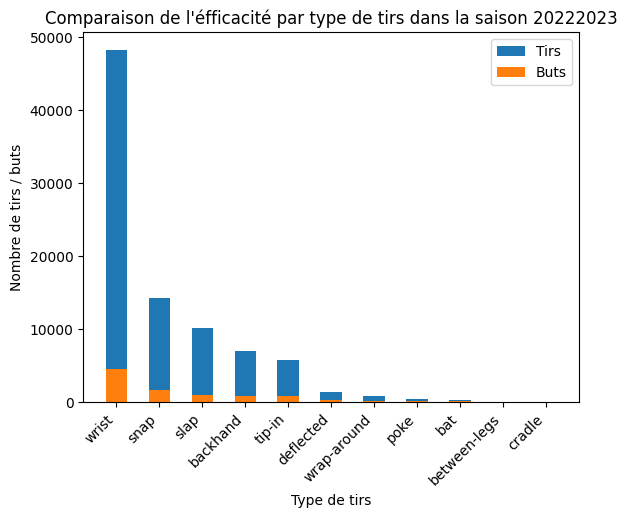

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Charger le fichier CSV
df = pd.read_csv('nhl_play_by_play_combined.csv')

# Sélectionner une saison spécifique (par exemple, 20222023)
season = '20222023'

    # Sélectionner la saison
df_season = df[df['season'] == int(season)]
    
# Obtenir les différents types de tirs
shot_types = df_season['shotType'].unique()

# Filtrer les tirs et obtenir les comptes
shot_counts = df_season['shotType'].value_counts()

    # Filtrer les buts et obtenir les comptes
goals = df_season[df_season['eventType'] == 'goal']
goal_counts = goals['shotType'].value_counts()

   

    # Tracer les données
x = np.arange(len(shot_counts.index))  # Emplacements des étiquettes
width = 0.5  # Largeur des barres

fig, ax = plt.subplots()

rects1 = ax.bar(x, shot_counts.values, width, label='Tirs')
rects2 = ax.bar(x, goal_counts.values, width, label='Buts')

#   # Ajouter des étiquettes et ajustements
ax.set_ylabel('Nombre')
ax.set_xlabel('Type de tirs')
ax.set_xticks(x)
ax.set_xticklabels(shot_counts.index, rotation=45, horizontalalignment='right', 
                       verticalalignment='top', fontsize='medium')
ax.legend()


plt.title(f"Comparaison de l'éfficacité par type de tirs dans la saison {season}")
plt.ylabel("Nombre de tirs / buts")
plt.xlabel("Type de tirs")
plt.legend()
plt.show()

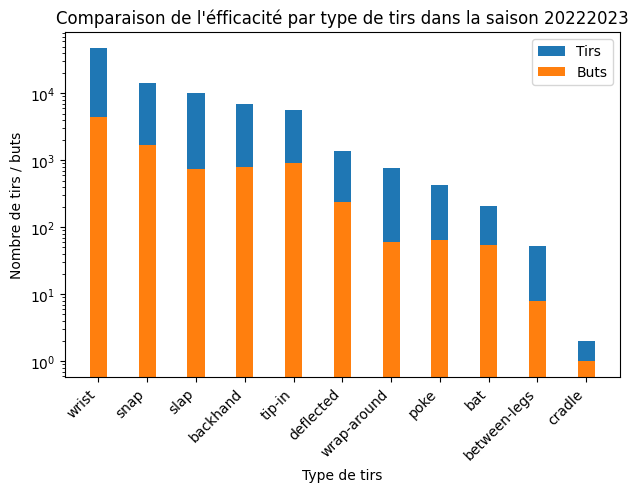

<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shots_goals_log(df, season):
    # Sélectionner la saison
    df_season = df[df['season'] == int(season)]
    
    # Obtenir les différents types de tirs
    shot_types = df_season['shotType'].unique()

    # Filtrer les tirs et obtenir les comptes
    shot_counts = df_season['shotType'].value_counts()

    # Filtrer les buts et obtenir les comptes
    goals = df_season[df_season['eventType'] == 'goal']
    goal_counts = goals['shotType'].value_counts()

    # Assurez-vous que les goal_counts et shot_counts ont les mêmes indices
    goal_counts = goal_counts.reindex(shot_counts.index, fill_value=0)

    # Tracer les données
    x = np.arange(len(shot_counts.index))  # Emplacements des étiquettes
    width = 0.35  # Largeur des barres

    fig, ax = plt.subplots()

    rects1 = ax.bar(x, shot_counts.values, width, label='Tirs')
    rects2 = ax.bar(x, goal_counts.values, width, label='Buts')

    # Ajouter des étiquettes et ajustements
    ax.set_ylabel('Nombre')
    ax.set_xlabel('Types de tirs')
    ax.set_xticks(x)
    ax.set_xticklabels(shot_counts.index, rotation=45, horizontalalignment='right', 
                       verticalalignment='top', fontsize='medium')
    ax.legend()

    # Utiliser une échelle logarithmique pour l'axe des ordonnées
    plt.yscale('log')
    fig.tight_layout()
    plt.title(f"Comparaison de l'éfficacité par type de tirs dans la saison {season}")
    plt.ylabel("Nombre de tirs / buts")
    plt.xlabel("Type de tirs")
    plt.legend()
    plt.show()

    plt.savefig(f'logscale_shots_goals_{season}.png')
    

# Exécution de la fonction pour une saison spécifique
plot_shots_goals_log(df, '20222023')


Le tir le plus dangereux

In [31]:
# Calculer la proportion de buts par rapport aux tirs pour chaque type de tir
goal_proportion = goal_counts / shot_counts
goal_proportion = goal_proportion.fillna(0)  # Remplir les NaN par 0 si aucun tir de ce type n'a abouti à un but

# Afficher les proportions de buts
print(goal_proportion)

shotType
backhand        0.111919
bat             0.255924
between-legs    0.153846
cradle          0.500000
deflected       0.169297
poke            0.154028
slap            0.075094
snap            0.118272
tip-in          0.158575
wrap-around     0.078406
wrist           0.092348
Name: count, dtype: float64


In [32]:
df.head()

gameId    season  teamHomeId     teamHome  teamAwayId  teamAway  \
0  2019020001  20192020          10  Maple Leafs           9  Senators   
1  2019020001  20192020          10  Maple Leafs           9  Senators   
2  2019020001  20192020          10  Maple Leafs           9  Senators   
3  2019020001  20192020          10  Maple Leafs           9  Senators   
4  2019020001  20192020          10  Maple Leafs           9  Senators   

   event_id     eventType  eventTeamId    eventTeam homeTeamDefendingSide  \
0        10          goal            9     Senators                 right   
1        15  shot-on-goal           10  Maple Leafs                 right   
2        20  shot-on-goal            9     Senators                 right   
3        21  shot-on-goal           10  Maple Leafs                 right   
4        24  shot-on-goal           10  Maple Leafs                 right   

   period periodTime  coordinateX  coordinateY    shooterName  \
0       1      00:25         85.0         -1.0        Unknown   
1       1      01:31        -32.0         -2.0  Morgan Rielly   
2       1      03:23         63.0         -6.0   Dylan DeMelo   
3       1      03:56        -59.0        -20.0  Morgan Rielly   
4       1      04:47        -42.0        -29.0   Tyson Barrie   

          goalieName shotType  emptyNet  strength  
0  Frederik Andersen   tip-in       NaN       NaN  
1     Craig Anderson     snap       NaN       NaN  
2  Frederik Andersen     snap       NaN       NaN  
3     Craig Anderson    wrist       NaN       NaN  
4     Craig Anderson     slap       NaN       NaN

In [33]:
import math

def calculate_distance(row, home_team_id, away_team_id):
    # Extraire les coordonnées
    x = row['xCoord']
    y = row['yCoord']
    event_team_id = row['eventOwnerTeamId']
    defending_side = row['homeTeamDefendingSide']

    # Vérifier si l'équipe est à domicile ou à l'extérieur
    if event_team_id == home_team_id:
        # Cas où l'équipe qui a fait l'événement est l'équipe à domicile
        if defending_side == "right":
            return math.sqrt(x**2 + (y + 86)**2)
        elif defending_side == "left":
            return math.sqrt(x**2 + (86 - y)**2)
        else:
            return None
    elif event_team_id == away_team_id:
        # Cas où l'équipe qui a fait l'événement est l'équipe à l'extérieur
        if defending_side == "right":
            return math.sqrt(x**2 + (86 - y)**2)
        elif defending_side == "left":
            return math.sqrt(x**2 + (y + 86)**2)
        else:
            return None
    else:
        return None



In [34]:
import pandas as pd
# Charger le fichier CSV
df = pd.read_csv('nhl_play_by_play_combined.csv')



In [35]:
print(df.columns)


Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength'],
      dtype='object')


In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def distance_vs_goal(season):
    # Sélectionner la saison
    df_season = df[df['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialize the distance list to store calculated distances
    distances = []

    # Iterate over each row to calculate distances
    for index, row in df_season.iterrows():
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row['homeTeamDefendingSide']

        # Check if the event team is the home team
        if event_team_id == home_team_id:
            # Si l'équipe de l'événement est l'équipe à domicile
            if defending_side == 'right':
                distance = np.sqrt((x+ 86)**2 + (y)**2)
            elif defending_side == 'left':
                distance = np.sqrt((x - 86)**2 + (y)**2)
            else:
                distance = None
        else:
            # Si l'équipe de l'événement est l'équipe extérieure
            if defending_side == 'right':
                distance = np.sqrt((x - 86)**2 + (y)**2)
            elif defending_side == 'left':
                distance = np.sqrt((x + 86)**2 + (y)**2)
            else:
                distance = None
        
        distances.append(distance)
    
    # Add the calculated distances back to the DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Filtrer uniquement les buts
    df_goals_only = df_season[df_season['eventType'] == 'goal']
    
    # Calculer le pourcentage de buts par distance
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
                                  df_season.groupby(['distance_round'])['eventType'].count()) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Pourcentage de buts')
    
    # Tracer le graphique
    sns.scatterplot(x=goal_score_percent_by_dist.index, y=goal_score_percent_by_dist)
    plt.title(f'Pourcentage de buts en fonction de la distance - Saison {season}')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"goal_percent_net_dist_{season}.png")
    plt.show()
    
    return df_goals_only

In [37]:
print(df.columns)

Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength'],
      dtype='object')


In [38]:
df_goals_only2 = distance_vs_goal(20182019)

No data found for the season 20182019.


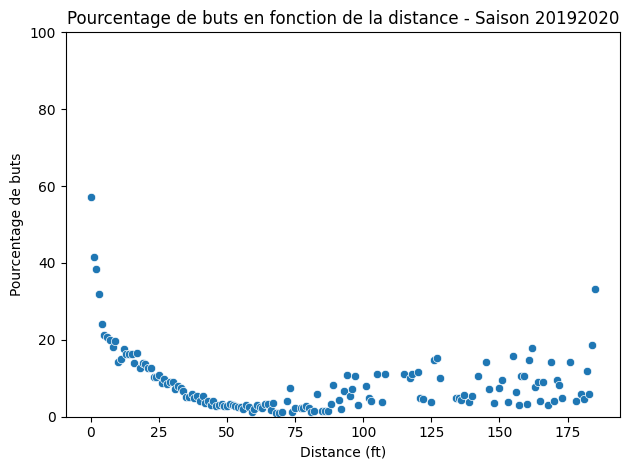

In [39]:
df_goals_only2 = distance_vs_goal(20192020)

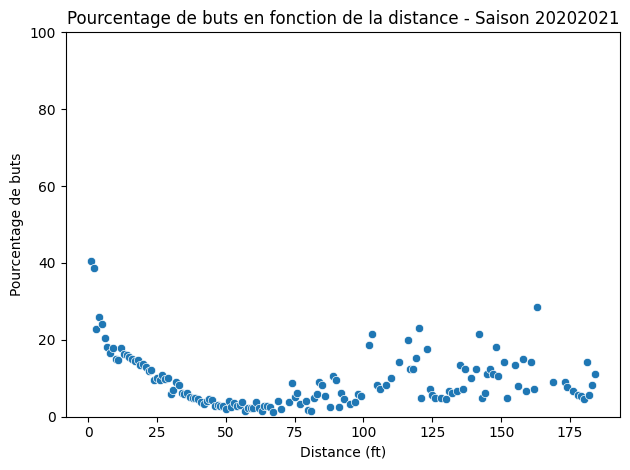

In [40]:
df_goals_only2 = distance_vs_goal(20202021)

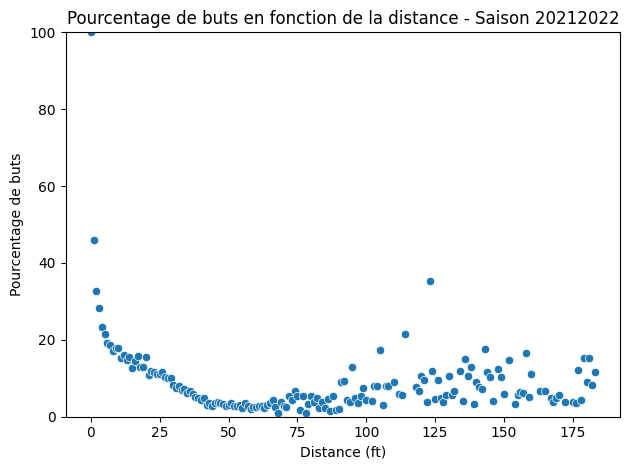

In [41]:
df_goals_only2 = distance_vs_goal(20212022)

In [42]:
print(df_season.columns)
print(df_goals_only.columns)

Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength'],
      dtype='object')


NameError: name 'df_goals_only' is not defined

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def df_goal(season):
    # Sélectionner la saison
    df_season = df[df['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialize the distance list to store calculated distances
    distances = []

    # Iterate over each row to calculate distances
    for index, row in df_season.iterrows():
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row['homeTeamDefendingSide']

        # Check if the event team is the home team
        if event_team_id == home_team_id:
            # Si l'équipe de l'événement est l'équipe à domicile
            if defending_side == 'right':
                distance = np.sqrt((x+ 86)**2 + (y)**2)
            elif defending_side == 'left':
                distance = np.sqrt((x - 86)**2 + (y)**2)
            else:
                distance = None
        else:
            # Si l'équipe de l'événement est l'équipe extérieure
            if defending_side == 'right':
                distance = np.sqrt((x - 86)**2 + (y)**2)
            elif defending_side == 'left':
                distance = np.sqrt((x + 86)**2 + (y)**2)
            else:
                distance = None
        
        distances.append(distance)
    
    # Add the calculated distances back to the DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Filtrer uniquement les buts
    df_goals_only = df_season[df_season['eventType'] == 'goal']
    
    # Calculer le pourcentage de buts par distance
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
                                  df_season.groupby(['distance_round'])['eventType'].count()) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Pourcentage de buts')
    
   
    return df_season, df_goals_only

In [44]:
df_season,df_goals_only=df_goal(20222023)
print(df_season.columns)
print(df_goals_only.columns)

Index(['index', 'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId',
       'teamAway', 'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength', 'distance', 'distance_round'],
      dtype='object')
Index(['index', 'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId',
       'teamAway', 'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'period', 'periodTime', 'coordinateX',
       'coordinateY', 'shooterName', 'goalieName', 'shotType', 'emptyNet',
       'strength', 'distance', 'distance_round'],
      dtype='object')


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def distance_pourcentage_buts_type_tirs(saison):
    df_saison, df_buts_seulement = df_goal(saison)
    
    # Calcul du pourcentage de buts par distance et type de tir
    pourcentage_buts_par_distance_et_tir = (
        df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
    ) * 100

    # Nettoyer et renommer les colonnes pour les rendre plus lisibles
    pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()
    pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.rename(
        columns={'eventType': 'Pourcentage de buts', 
                 'distance_round': 'Distance (pieds)', 
                 'shotType': 'Type de tir'}
    )
    
    # Création du graphique
    plt.figure(figsize=(20, 10))
    plt.rcParams["axes.labelsize"] = 16    
    plt.rcParams.update({'font.size': 16})
    
    ax = sns.relplot(
        x=pourcentage_buts_par_distance_et_tir['Distance (pieds)'], 
        y=pourcentage_buts_par_distance_et_tir['Pourcentage de buts'], 
        col=pourcentage_buts_par_distance_et_tir['Type de tir'],
        col_wrap=3,
    )

    # Ajouter le titre principal
    plt.suptitle(f'Pourcentage de buts (tirs/buts) en fonction de la distance et du type de tir - {saison}', fontsize=16)
    
    # Ajustement de la mise en page et sauvegarde
    ax.fig.subplots_adjust(top=0.9)
    ax.tight_layout()
    plt.savefig(f'pourcentage_buts_vs_distance_type_tir{saison}.png')

    return None

<Figure size 2000x1000 with 0 Axes>

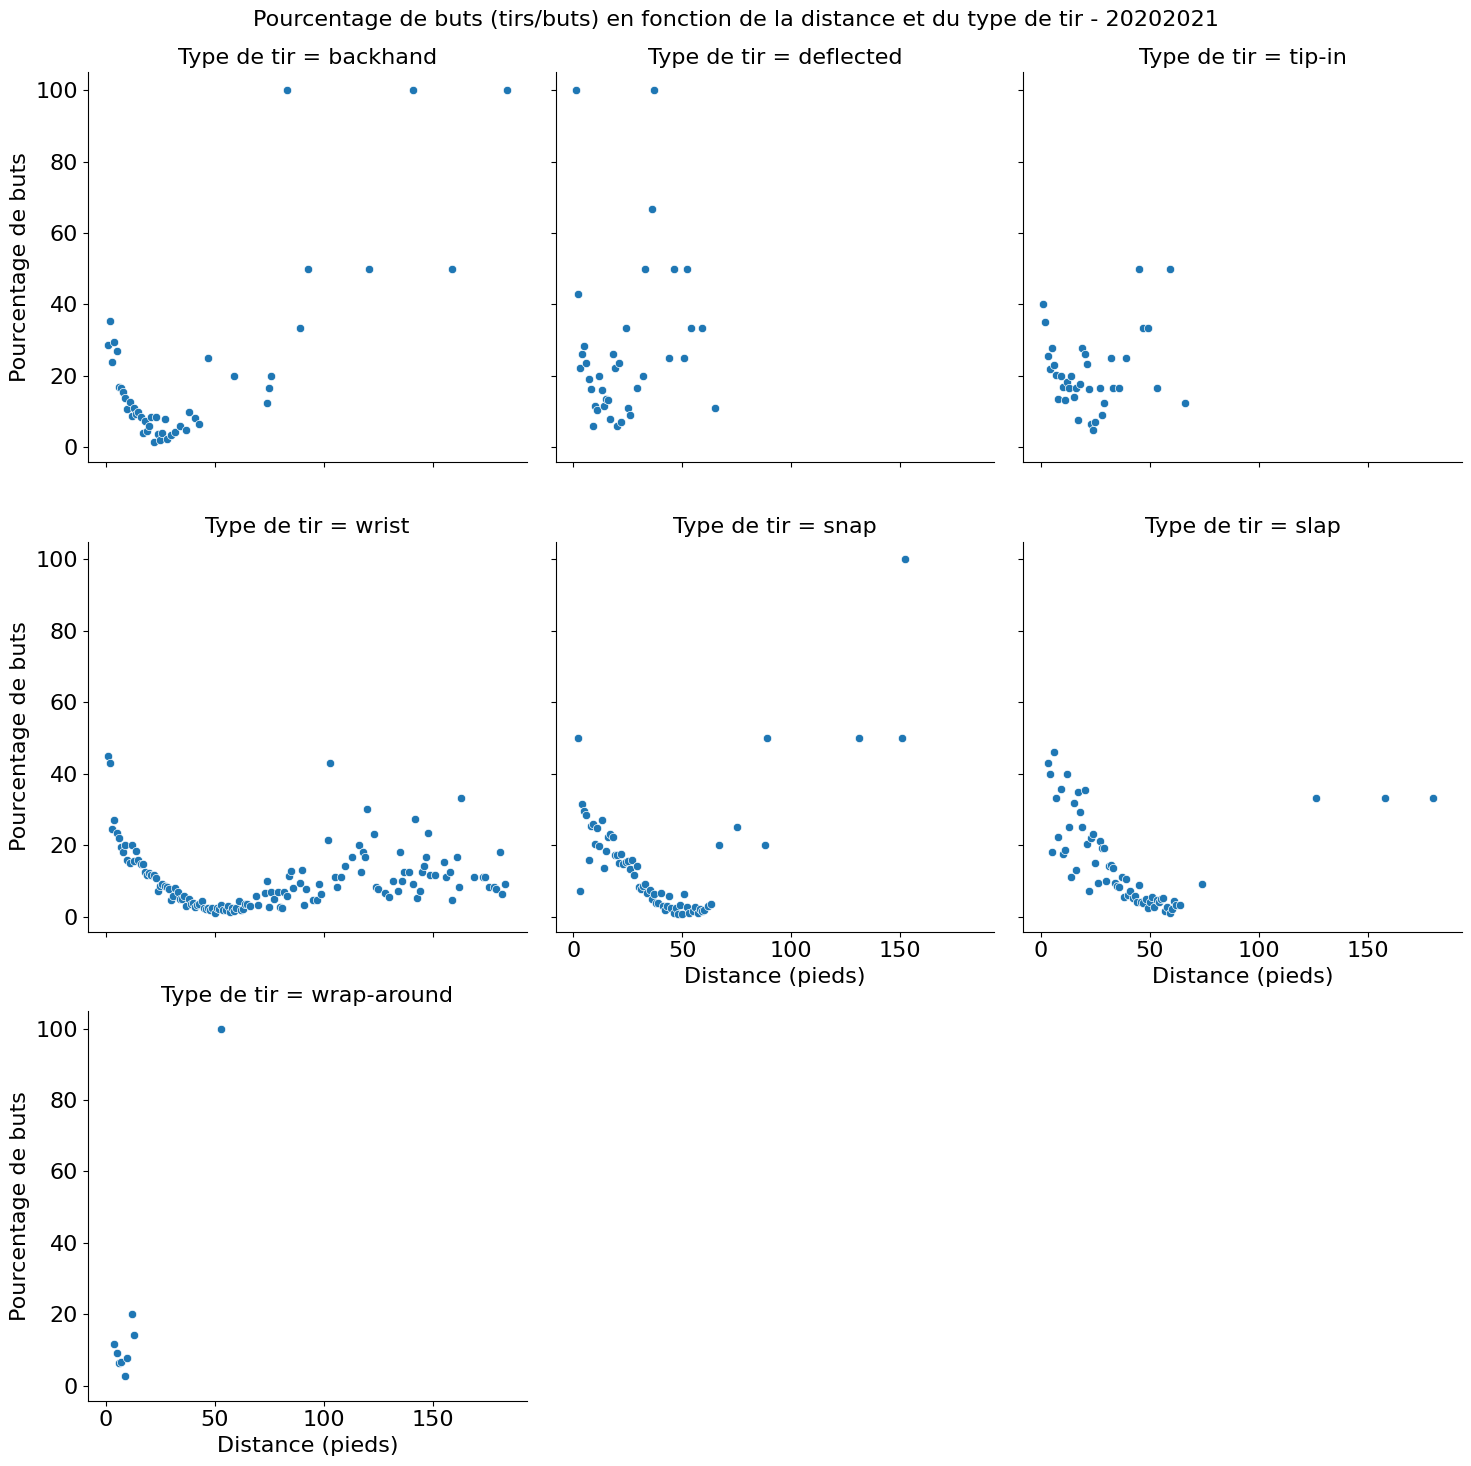

In [46]:
distance_pourcentage_buts_type_tirs(20202021)

In [48]:
# Calculer la proportion de buts par rapport aux tirs pour chaque type de tir
df_saison, df_buts_seulement = df_goal(20202021)
    
    # Calcul du pourcentage de buts par distance et type de tir
pourcentage_buts_par_distance_et_tir = (
        df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
    ) * 100

    # Nettoyer et renommer les colonnes pour les rendre plus lisibles
pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()
print(pourcentage_buts_par_distance_et_tir)

     distance_round   shotType   eventType
1               1.0   backhand   28.571429
2               1.0  deflected  100.000000
4               1.0     tip-in   40.000000
5               1.0      wrist   45.000000
6               2.0   backhand   35.294118
..              ...        ...         ...
828           180.0       slap   33.333333
833           181.0      wrist   18.181818
836           182.0      wrist    6.250000
838           183.0      wrist    9.090909
839           184.0   backhand  100.000000

[401 rows x 3 columns]


# Le eventType qui donne le pourcentage max des buts par distance

In [49]:
import pandas as pd
import numpy as np

# Supposons que df_saison et df_buts_seulement soient déjà définis
df_saison, df_buts_seulement = df_goal(20202021)

# Calcul du pourcentage de buts par distance et type de tir
pourcentage_buts_par_distance_et_tir = (
    df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
    df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
) * 100

# Nettoyer et renommer les colonnes pour les rendre plus lisibles
pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()

# Ajouter une colonne pour les intervalles de distance
def assign_distance_interval(distance):
    if distance < 30:
        return '0-30'
    elif distance < 60:
        return '30-60'
    elif distance < 90:
        return '60-90'
    elif distance < 120:
        return '90-120'
    elif distance < 150:
        return '120-150'
    elif distance <= 180:
        return '150-180'
    else:
        return '180+'

pourcentage_buts_par_distance_et_tir['intervalle_distance'] = pourcentage_buts_par_distance_et_tir['distance_round'].apply(assign_distance_interval)

# Calculer la moyenne des pourcentages de buts par type de tir et par intervalle de distance
moyennes_par_intervalle = pourcentage_buts_par_distance_et_tir.groupby(['intervalle_distance', 'shotType'])['eventType'].mean().reset_index()
moyennes_par_intervalle = moyennes_par_intervalle.rename(columns={'eventType': 'Moyenne Pourcentage de Buts'})

# Affichage des résultats
#print(moyennes_par_intervalle)

# Tri des données par ordre croissant des intervalles de distance et en fonction du pourcentage de buts
moyennes_par_intervalle = moyennes_par_intervalle.sort_values(by=['intervalle_distance', 'Moyenne Pourcentage de Buts'], ascending=[True, False])

# Filtrer pour garder uniquement le type de tir ayant le pourcentage de buts le plus élevé dans chaque intervalle
max_pourcentage_par_intervalle = moyennes_par_intervalle.groupby('intervalle_distance').first().reset_index()

# Afficher le résultat
print(max_pourcentage_par_intervalle)

  intervalle_distance     shotType  Moyenne Pourcentage de Buts
0                0-30         slap                    25.095833
1             120-150     backhand                    75.000000
2             150-180         snap                    75.000000
3                180+     backhand                   100.000000
4               30-60  wrap-around                   100.000000
5               60-90     backhand                    36.500000
6              90-120     backhand                    50.000000


# Le eventType qui donne le pourcentage min des buts par distance

In [50]:
# Trier les données par intervalle de distance et pourcentage de buts en ordre croissant
moyennes_par_intervalle = moyennes_par_intervalle.sort_values(by=['intervalle_distance', 'Moyenne Pourcentage de Buts'])

# Extraire le type de tir avec le pourcentage de buts minimum pour chaque intervalle de distance
min_pourcentage_par_intervalle = moyennes_par_intervalle.groupby('intervalle_distance').first().reset_index()

# Afficher le eventype qui donne le pourcentage min des buts
print(min_pourcentage_par_intervalle)

  intervalle_distance     shotType  Moyenne Pourcentage de Buts
0                0-30  wrap-around                     9.794241
1             120-150        wrist                    13.293601
2             150-180        wrist                    12.253427
3                180+        wrist                    11.174242
4               30-60        wrist                     3.412156
5               60-90         slap                     4.404495
6              90-120        wrist                    13.418641


Visualisations avancées

In [51]:
import pandas as pd
# Charger le fichier CSV
df = pd.read_csv('nhl_play_by_play_combined.csv')

In [55]:
df.columns
df.head(5)

gameId    season  teamHomeId     teamHome  teamAwayId  teamAway  \
0  2019020001  20192020          10  Maple Leafs           9  Senators   
1  2019020001  20192020          10  Maple Leafs           9  Senators   
2  2019020001  20192020          10  Maple Leafs           9  Senators   
3  2019020001  20192020          10  Maple Leafs           9  Senators   
4  2019020001  20192020          10  Maple Leafs           9  Senators   

   event_id     eventType  eventTeamId    eventTeam homeTeamDefendingSide  \
0        10          goal            9     Senators                 right   
1        15  shot-on-goal           10  Maple Leafs                 right   
2        20  shot-on-goal            9     Senators                 right   
3        21  shot-on-goal           10  Maple Leafs                 right   
4        24  shot-on-goal           10  Maple Leafs                 right   

   period periodTime  coordinateX  coordinateY    shooterName  \
0       1      00:25         85.0         -1.0        Unknown   
1       1      01:31        -32.0         -2.0  Morgan Rielly   
2       1      03:23         63.0         -6.0   Dylan DeMelo   
3       1      03:56        -59.0        -20.0  Morgan Rielly   
4       1      04:47        -42.0        -29.0   Tyson Barrie   

          goalieName shotType  emptyNet  strength  
0  Frederik Andersen   tip-in       NaN       NaN  
1     Craig Anderson     snap       NaN       NaN  
2  Frederik Andersen     snap       NaN       NaN  
3     Craig Anderson    wrist       NaN       NaN  
4     Craig Anderson     slap       NaN       NaN

In [72]:
unique_values = df['eventType'].unique()
print(unique_values)

['goal' 'shot-on-goal']


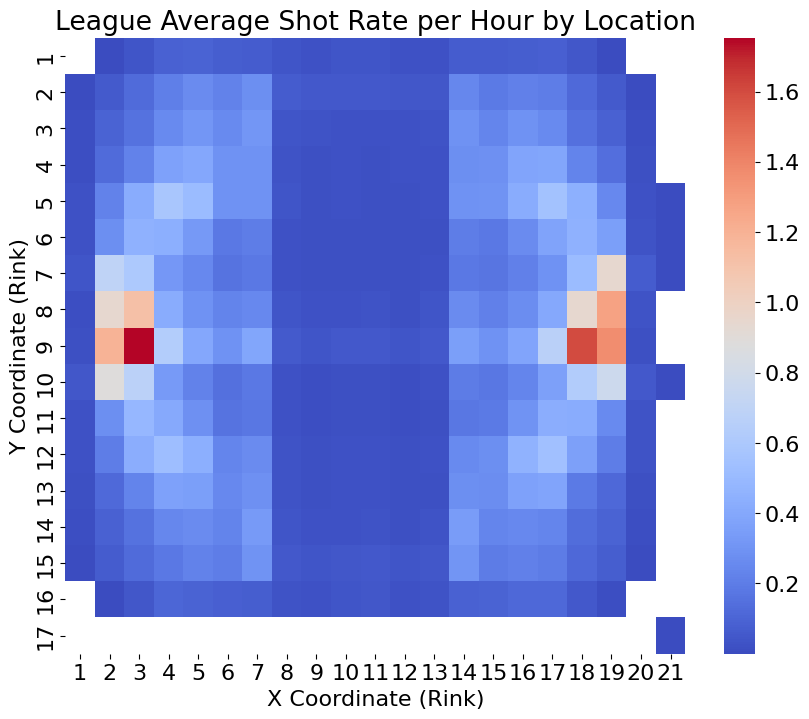

In [73]:
import pandas as pd
import numpy as np


# Step 1: Filter shot data
shot_data = df[df['eventType'].isin(['goal', 'shot-on-goal'])]

# Step 2: Define the grid (assuming a rink width of 100 and height of 85 units)
x_bins = np.linspace(-100, 100, 21)  # 20 x-axis grid divisions
y_bins = np.linspace(-42.5, 42.5, 17)  # 16 y-axis grid divisions

# Step 3: Assign each shot to a grid cell
shot_data['x_bin'] = np.digitize(shot_data['coordinateX'], x_bins)
shot_data['y_bin'] = np.digitize(shot_data['coordinateY'], y_bins)

# Step 4: Count shots per location
shot_counts = shot_data.groupby(['x_bin', 'y_bin']).size().reset_index(name='shot_count')

# Step 5: Calculate total hours of gameplay
total_games = df['gameId'].nunique()
total_minutes = total_games * 60  # Assuming each game is 60 minutes long
total_hours = total_minutes / 60  # Convert to hours

# Step 6: Calculate shot rate per hour
shot_counts['shot_rate_per_hour'] = shot_counts['shot_count'] / total_hours

import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the data to create a matrix for heatmap
shot_rate_matrix = shot_counts.pivot(index='y_bin', columns='x_bin', values='shot_rate_per_hour')

# Plot using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(shot_rate_matrix, cmap='coolwarm', annot=False)
plt.title('League Average Shot Rate per Hour by Location')
plt.xlabel('X Coordinate (Rink)')
plt.ylabel('Y Coordinate (Rink)')
plt.show()



In [77]:
import pandas as pd

# Assuming 'df' is your play-by-play dataframe and contains columns 'team', 'x', 'y', 'game_id'

# Step 1: Filter shots data and group by team
shot_data = df[df['eventType'].isin(['goal', 'shot-on-goal'])]

# Group by team and calculate total shots for each team
team_shot_counts = shot_data.groupby('eventTeam').size().reset_index(name='total_shots')

# Step 2: Calculate the total time played for all games (as hours)
total_games = df['gameId'].nunique()
total_hours = total_games * 60 / 60  # Assuming each game lasts 60 minutes

# Step 3: Calculate the league-wide average shot rate per hour (using your previously calculated shot counts)
league_total_shots = shot_data.shape[0]
league_shot_rate_per_hour = league_total_shots / total_hours

# Step 4: Calculate shot rate per hour for each team
team_shot_counts['shot_rate_per_hour'] = team_shot_counts['total_shots'] / total_hours

# Step 5: Compute the difference between each team's shot rate and the league-wide average
# You can choose to calculate the raw difference or the percentage difference
team_shot_counts['shot_rate_difference_raw'] = team_shot_counts['shot_rate_per_hour'] - league_shot_rate_per_hour
team_shot_counts['shot_rate_difference_percentage'] = (team_shot_counts['shot_rate_per_hour'] / league_shot_rate_per_hour - 1) * 100

# Display the results
print(team_shot_counts[['eventTeam', 'shot_rate_per_hour', 'shot_rate_difference_raw', 'shot_rate_difference_percentage']])


         eventTeam  shot_rate_per_hour  shot_rate_difference_raw  \
0        Avalanche            2.319886                -60.044297   
1       Blackhawks            1.705585                -60.658598   
2     Blue Jackets            1.813321                -60.550862   
3            Blues            1.860782                -60.503401   
4           Bruins            2.183041                -60.181142   
5        Canadiens            1.903338                -60.460845   
6          Canucks            1.877551                -60.486632   
7         Capitals            1.873280                -60.490903   
8          Coyotes            1.654960                -60.709223   
9           Devils            1.908717                -60.455466   
10           Ducks            1.677424                -60.686758   
11          Flames            2.067236                -60.296947   
12          Flyers            1.893055                -60.471128   
13  Golden Knights            2.282234          

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from ipywidgets import interact

# Step 1: Filter for shot-related events ('SHOT' or 'GOAL')
shots_data = df[df['eventType'].isin(['shot', 'shot-on-goal'])]

# Step 2: Function to compute KDE and return the grid and KDE values for a specific team
def compute_team_kde(team_name):
    # Filter for the specific team's shots
    team_shots = shots_data[shots_data['eventTeam'] == team_name]
    
    # Extract the x and y coordinates of the shots
    x_coords = team_shots['coordinateX'].values
    y_coords = team_shots['coordinateY'].values

    # Apply KDE with Gaussian kernel
    xy_coords = np.vstack([x_coords, y_coords])
    kde = gaussian_kde(xy_coords, bw_method='scott')  # Adjust 'bw_method' if needed

    # Create a grid over the ice to evaluate KDE
    x_grid = np.linspace(-100, 100, 200)  # X coordinates (rink width)
    y_grid = np.linspace(-42.5, 42.5, 100)  # Y coordinates (rink height)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Evaluate KDE on the grid
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    
    return X, Y, Z  # Return the grid and KDE values

# Step 3: Function to create the Matplotlib heatmap for a selected team
def create_plot(team_name):
    X, Y, Z = compute_team_kde(team_name)
    
    # Plot using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, cmap='coolwarm')
    plt.colorbar(label='Shot Density')
    
    plt.title(f'Shot Density Heatmap for {team_name}')
    plt.xlabel('X Coordinate (Rink)')
    plt.ylabel('Y Coordinate (Rink)')
    
    plt.show()

# Step 4: Get all unique teams
teams = shots_data['eventTeam'].unique()

# Step 5: Create an interactive dropdown menu to select team and display the heatmap
interact(create_plot, team_name=teams)


interactive(children=(Dropdown(description='team_name', options=('Maple Leafs', 'Senators', 'Capitals', 'Blues…

<function __main__.create_plot(team_name)>

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from ipywidgets import interact



# Step 1: Filter for shot-related events ('SHOT' or 'GOAL') and only in the offensive zone (x > 0)
def filter_offensive_zone_shots(df):
    return df[(df['eventType'].isin(['shot', 'shot-on-goal'])) & (df['coordinateX'] > 0)]

# Filter data for the offensive zone
offensive_shots_data = filter_offensive_zone_shots(df)

# Step 2: Function to compute KDE and return the grid and KDE values for a specific team and season
def compute_team_season_kde(team_name, season):
    # Filter for the specific team's shots and season
    team_season_shots = offensive_shots_data[(offensive_shots_data['eventTeam'] == team_name) &
                                             (offensive_shots_data['season'] == season)]
    
    # Extract the x and y coordinates of the shots
    x_coords = team_season_shots['coordinateX'].values
    y_coords = team_season_shots['coordinateY'].values

    # Apply KDE with Gaussian kernel
    xy_coords = np.vstack([x_coords, y_coords])
    kde = gaussian_kde(xy_coords, bw_method='scott')  # Adjust 'bw_method' if needed

    # Create a grid over the offensive zone to evaluate KDE
    x_grid = np.linspace(0, 100, 200)  # Offensive zone: x > 0
    y_grid = np.linspace(-42.5, 42.5, 100)  # Y coordinates (rink height)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Evaluate KDE on the grid
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    
    return X, Y, Z  # Return the grid and KDE values

# Step 3: Function to create the Matplotlib heatmap for a selected team and season
def create_plot(team_name, season):
    X, Y, Z = compute_team_season_kde(team_name, season)
    
    # Plot using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, cmap='coolwarm')
    plt.colorbar(label='Shot Density')
    
    plt.title(f'Shot Density Heatmap for {team_name} in {season}')
    plt.xlabel('X Coordinate (Offensive Zone)')
    plt.ylabel('Y Coordinate (Rink)')
    
    plt.show()

# Step 4: Get all unique teams and seasons
teams = offensive_shots_data['eventTeam'].unique()
seasons = offensive_shots_data['season'].unique()

# Step 5: Create an interactive dropdown menu to select season and team, and display the heatmap
interact(create_plot, team_name=teams, season=seasons)


interactive(children=(Dropdown(description='team_name', options=('Senators', 'Maple Leafs', 'Blues', 'Capitals…

<function __main__.create_plot(team_name, season)>